# Flagship figure

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

# import tsne
import sys#; import os
sys.path.append('../../FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function
# sys.path.append('../rna-seq-tsne')
import rnaseqTools

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'counts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

with np.errstate(invalid='ignore'):
    layers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    layers[normdepth < 0.07] = '1'
    layers[(normdepth > 0.07) & (normdepth > 0.29)] = '2/3'
    layers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    layers[normdepth > 0.73] = '6'

In [3]:
with open('../data/processed/ephys/three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)

for c in list(three_traces.keys()):
    three_traces[c[:8]+'_sample_'+c[14:]] = three_traces.pop(c)

In [4]:
import os
swcfiles = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/excitatory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/inhibitory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {} .SWC files'.format(len(swcfiles)))
              
for i in np.where(m1.traced)[0]:
    if m1.cells[i] not in swcfiles:
        print('SWC not found: ' + m1.cells[i])
for c in swcfiles:
    if np.sum(m1.cells==c)==0:
        print('Not in the spreadsheet: ' + c + '\n' + swcfiles[c] + '')
    elif ~m1.traced[m1.cells==c]:
        print('Not marked as traced: ' + c)

Found 642 .SWC files


In [5]:
def plot_swc(file_path, ax, offset=0, depth=500.0, thickness=1000.0,
             dendrite_color='r', axon_color='darkgreen', soma_color='k', 
             s=.05, minwidth=0, soma_s=3):
    
    swc = pd.read_csv(file_path, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    dendrites = swc['type'] == 3
    axons = swc['type'] == 2
    soma = swc['type'] == 1
    
    swc['x'] = swc['x']/thickness
    swc['y'] = swc['y']/thickness
        
    soma_loc = swc.iloc[0][['x', 'y']]
    soma_loc['y'] = soma_loc['y'] + depth/thickness
    
    to_plot = np.zeros_like(dendrites)
    if dendrite_color!='none':
        to_plot |= dendrites
    if axon_color!='none':
        to_plot |= axons
    width = np.max(swc['x'][to_plot]) - np.min(swc['x'][to_plot])
    offset += np.abs(np.min(swc['x'][to_plot]-soma_loc['x']))
    if width < minwidth:
        offset += (minwidth-width)/2
        width = minwidth  
    soma_loc['x'] = soma_loc['x'] - offset
    
    if dendrite_color!='none':
        ax.scatter(swc['x'][dendrites]-soma_loc['x'], swc['y'][dendrites]-soma_loc['y'], 
                   s=s, c=dendrite_color, edgecolors='none', rasterized=True)
    if axon_color!='none':
        ax.scatter(swc['x'][axons]-soma_loc['x'], swc['y'][axons]-soma_loc['y'], 
                s=s, c=axon_color, edgecolors='none', rasterized=True)
    if soma_color!='none':
        ax.scatter(swc['x'][soma]-soma_loc['x'], swc['y'][soma]-soma_loc['y'], 
                s=s, c=soma_color, edgecolors='none', rasterized=True)
    else:
        ax.scatter(offset, -depth/thickness, s=soma_s, c='k', edgecolors='none')
            
    return width


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))

In [6]:
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-big.pickle', 'rb'))

pos = rnaseqTools.map_to_tsne(m1data['neurons']['counts'],
                              m1data['neurons']['genes'],
                              m1.counts[ttypes['qc']=='good',:], m1.genes, Z, knn=10)

Using a common set of 964 genes.
Processing in batches.. done


<IPython.core.display.Javascript object>


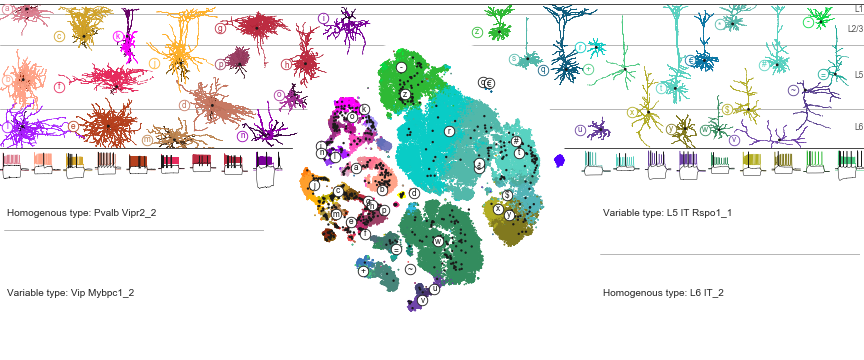

In [11]:
plt.figure(figsize=(7.2, 3))
aspect = 7.2/3

h = .8
ax_tsne = plt.axes([.5 - h/aspect/2, .5-h/2, h/aspect, h])
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1,
            c = clusterColors[m1data['neurons']['clusters']], edgecolor='none')

plt.scatter(pos[:,0], pos[:,1], s=2, c='k', zorder=2, edgecolors='none')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_tsne, left=True, bottom=True)

ax_tsne.patch.set_alpha(0)
circle = plt.Circle((0, 0), 115, color='w', zorder=-1)
ax_tsne.add_artist(circle)

###########################################

ax_cortex = plt.axes([0, .59, 1, .4], zorder=-1)
plt.ylim([-1,0])
plt.xlim([0, aspect / (1.02*.4)])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_cortex, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
for y,L in zip([-0.04,-0.18,-0.5,-0.86], ['L1', 'L2/3', 'L5', 'L6']):
    plt.text(5.88, y, L, fontsize=5, color='#555555', va='center', ha='right') 
    
ax_ephys = plt.axes([0,.47,1,.15], zorder=-2)
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ephys, left=True, bottom=True)
plt.xlim([0,30])
plt.ylim([-200,150])

ax_example_inhHom = plt.axes([.005,.23,.3,.2])
plt.xlim([0, aspect/ (1.02*.4) * .3])
plt.ylim([-.2/.4 + .1, 0.1])
plt.plot(plt.xlim(), [-.07,-.07], linewidth=.5, zorder=0, color='#aaaaaa')
plt.text(.01, .85, 'Homogenous type: Pvalb Vipr2_2', fontsize=6, transform=ax_example_inhHom.transAxes)

ax_example_inhVar = plt.axes([.005,.05,.3,.15])
plt.xlim([0, 30 * .3])
plt.ylim([-200,150])
plt.text(.01, .85, 'Variable type: Vip Mybpc1_2', fontsize=6, transform=ax_example_inhVar.transAxes)

ax_example_excHom = plt.axes([1-.005-.3,.05,.3,.15])
plt.xlim([0, 30 * .3])
plt.ylim([-200,150])
plt.text(.01, .85, 'Homogenous type: L6 IT_2', fontsize=6, transform=ax_example_excHom.transAxes)

ax_example_excVar = plt.axes([1-.005-.3,.23,.3,.2])
plt.xlim([0, aspect / (1.02*.4) * .3])
plt.ylim([-.2/.4 + 0.05, .05])
plt.plot(plt.xlim(), [-.29,-.29], linewidth=.5, zorder=0, color='#aaaaaa')
plt.text(.01, .85, 'Variable type: L5 IT Rspo1_1', fontsize=6, transform=ax_example_excVar.transAxes)

for ax in [ax_example_inhHom, ax_example_inhVar, ax_example_excHom, ax_example_excVar]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)


neurons_to_show = {952: 0,  # L1 Lamp5
                   1232: 0, # L5 NGC
                   322: .4, # L2/3 MC
                   574: 1.2, # fat Lhx6 NGC
                   779: .5, # fat L6 Pvalb
                   126: .4, # L5 HEC
                   328: 1.5,  # L2/3 BC
                   388: 1.95,   # L5 BC
                   951: 2.2, # Sncg
                   960: 1, # T-shape MC
                   864: .8, # bipolar
                   1218: 0,  # L6 Serpinf
                   887: 1, # L6b Sst,
                   765: 1.65, # L6 Sncg,
                   1207: 1.9, # L5 Vip 
                   671: 1.5,  # shrub
                   #641: 1.7, # deep chandelier
                   
                   7: 3.7,  # L5 ET
                   1101: 4, # stellate in L4
                   317: 3.5, # untufted in upper L5
                   59: 4.5, # deep tufted
                   667: 4, #L6b small
                   1273: 5, # L6b wide
                   797: 4.8, # L6 CT
                   688: 4.3, # L6 IT
                   760: 4.57, # L6 IT small
                   392: 3.3, # L2/3
                   1202: 4, # NP,
                   168: 4.9, # L2/3 Rspo
                   119: 5.2, # big L5 IT
                   770: 5.4, # inverted in L5
                   1197: 4.95, # L6 IT high
                   14: 4.7, # smaller ET
                   1228: 5.6, # NP CT
                   116: 5.5, # L2/3 IT_2
                  }

alphabet = 'abcdefghijklmnopqrstuvwxyz+*#~$€=-><@^'
adj_vert = {'*':-.015, 'i':-.005,'$':-0.01,'€':-0.01,'h':-0.01,'=':-0.01,'~':-0.01}
adj_hor = {952:.05, 1232:.05, 1218:.05, 960:.05, 574:.05, 
           392:-.05, 1101:-.05, 1201:.1, 667:-.05}

for num,n in enumerate(neurons_to_show):
    i = n-2
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]
    if np.isin(ttypes['family'][i], ['IT','PT','NP','CT']):
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
    
    plot_swc(swcfiles[m1.cells[i]], ax=ax_cortex, 
             depth=m1.depth[i], thickness=m1.thickness[i], offset=neurons_to_show[n],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none')

    if alphabet[num]!='jjj':
        dy = 0
        if alphabet[num] in adj_vert:
            dy += adj_vert[alphabet[num]]
        dx = 0
        if n in adj_hor:
            dx += adj_hor[n]
        ax_cortex.scatter(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i], 
                          s=40, c='w', zorder=3, edgecolors=col, linewidth=.5)
        ax_cortex.text(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i]+dy,
                       alphabet[num], fontsize=5, ha='center', va='center', color=col)

        good_ind = np.sum(ttypes['qc'][:i]=='good')
        ax_tsne.scatter(pos[good_ind,0], pos[good_ind,1], s=40, c='w', zorder=3, edgecolors='k', linewidth=.5)
        ax_tsne.text(pos[good_ind,0], pos[good_ind,1]+dy*100, alphabet[num], fontsize=5, ha='center', va='center', color='k')
    
    if num < 9 or (num > 17 and num < 27):
        time = three_traces[m1.cells[i]][:,3]
        traces = three_traces[m1.cells[i]][:,:3]
        t = time + num*1.1
        if num > 17:
            t += .4
        ax_ephys.plot(t, traces[:,2], color=col, linewidth=.3)
        ax_ephys.plot(t, traces[:,1], color='k', linewidth=.3)
        ax_ephys.plot(t, traces[:,0], color='k', linewidth=.3)
        
    
        
#######################

# for num,n in enumerate([926,937,940,954,956,985,987]):
#     i = n-2
#     typ = ttypes['type'][i]
#     col = clusterColors[clusterNames==typ][0]
#     ax_col = col
#     den_col = [adjust_lightness(col,.4)]
    
#     plot_swc(swcfiles[m1.cells[i]], ax=ax_example_inhHom, 
#              depth=m1.depth[i], thickness=m1.thickness[i], offset=.03 + num * 0.25,
#              axon_color=ax_col, dendrite_color=den_col, soma_color='none')
    

# for num,n in enumerate([85,93,94,95,149,152,187]):
#     i = n-2
#     typ = m1rna['final_type'][i]
#     col = clusterColors[clusterNames==typ][0]
#     ax_col = 'none'
#     den_col = col
    
#     plot_swc(swcfiles[m1.cells[i]], ax=ax_exampleUR, 
#              depth=m1.depth[i], thickness=m1.thickness[i], offset=.03 + num * 0.25,
#              axon_color=ax_col, dendrite_color=den_col, soma_color='none') 
    
    
# for num,n in enumerate([825,1101,1132,1164,1170,1200,87,822]):
# for num,n in enumerate([126, 644, 386, ]):
#     i = n-2
#     typ = ttypes['type'][i]
#     col = clusterColors[clusterNames==typ][0]
#     ax_col = 'none'
#     den_col = col
    
#     plot_swc(swcfiles[m1.cells[i]], ax=ax_example_excVar, 
#              depth=m1.depth[i], thickness=m1.thickness[i], offset=.03 + num * 0.22,
#              axon_color=ax_col, dendrite_color=den_col, soma_color='none')   
    
# for num,n in enumerate([818,894,865,1007,849,917,920,904]):
#     i = n-2
#     typ = m1rna['final_type'][i]
#     col = clusterColors[clusterNames==typ][0]
    
#     time = three_traces[m1.cells[i]][:,3]
#     traces = three_traces[m1.cells[i]][:,:3]
#     t = time + num*1.1 + 0.1
#     ax_example_inhVar.plot(t, traces[:,2], color=col, linewidth=.3)
#     ax_example_inhVar.plot(t, traces[:,1], color='k', linewidth=.3)
#     ax_example_inhVar.plot(t, traces[:,0], color='k', linewidth=.3)    
    
# for num,n in enumerate([622,653,660,664,683,722,726,739]):
#     i = n-2
#     typ = ttypes['type'][i]
#     col = clusterColors[clusterNames==typ][0]
    
#     time = three_traces[m1.cells[i]][:,3]
#     traces = three_traces[m1.cells[i]][:,:3]
#     t = time + num*1.1 + 0.1
#     ax_example_excHom.plot(t, traces[:,2], color=col, linewidth=.3)
#     ax_example_excHom.plot(t, traces[:,1], color='k', linewidth=.3)
#     ax_example_excHom.plot(t, traces[:,0], color='k', linewidth=.3)
    
    
# pika = plt.imread('pikachu.png')
# ax_cortex.imshow(pika, extent=[1, 1.1, -.49,-.39], aspect='auto', zorder=10)
# ax_tsne.imshow(pika, extent=[-102,-88,-14,0], zorder=10)
# ax_tsne.set_xlim([-125,120])
# ax_tsne.set_ylim([-125,120])
    
bbox = matplotlib.transforms.Bbox([[0, .15],[7.2, 3]])
# plt.savefig('figures/flagship/flagship-patchseq-nopikachu.png', dpi=300, bbox_inches=bbox)

<IPython.core.display.Javascript object>


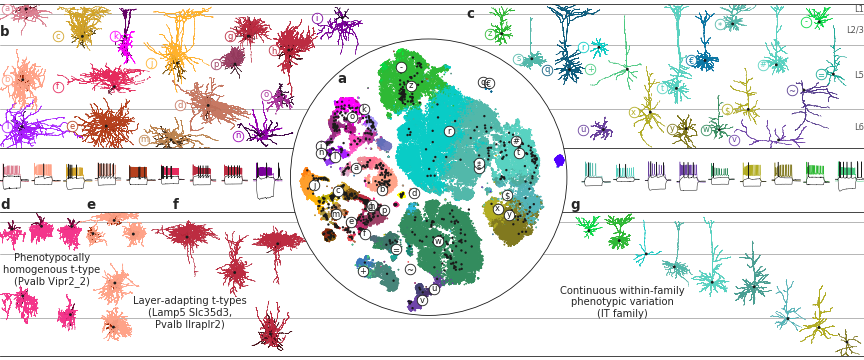

In [21]:
fig = plt.figure(figsize=(7.2, 3))
aspect = 7.2/3

h = .8
ax_tsne = plt.axes([.5 - h/aspect/2, .5-h/2, h/aspect, h])
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1,
            c = clusterColors[m1data['neurons']['clusters']], edgecolor='none')

plt.scatter(pos[:,0], pos[:,1], s=2, c='k', zorder=2, edgecolors='none')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_tsne, left=True, bottom=True)

ax_tsne.patch.set_alpha(0)
circle = plt.Circle((0, 0), 115, facecolor='w', zorder=-1, edgecolor='k', linewidth=.5)
# circle = plt.Circle((0, 0), 115, color='w', zorder=-1)
ax_tsne.add_artist(circle)

###########################################

ax_cortex = plt.axes([0, .59, 1, .4], zorder=-1)
plt.ylim([-1,0])
plt.xlim([0, aspect/.4])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_cortex, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
for y,L in zip([-0.04,-0.18,-0.5,-0.86], ['L1', 'L2/3', 'L5', 'L6']):
    plt.text(aspect/.4, y, L, fontsize=5, color='#555555', va='center', ha='right') 
    
ax_ephys = plt.axes([0,.44, 1,.15], zorder=-2)
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ephys, left=True, bottom=True)
plt.xlim([0,30])
plt.ylim([-200,150])

ax_cortex2 = plt.axes([0, 0.01, 1, .4], zorder=-1)
plt.ylim([-1,0])
plt.xlim([0, aspect/.4])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_cortex2, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
    
    
neurons_to_show = {952: 0,  # L1 Lamp5
                   1232: 0, # L5 NGC
                   322: .4, # L2/3 MC
                   574: 1.2, # fat Lhx6 NGC
                   779: .5, # fat L6 Pvalb
                   126: .4, # L5 HEC
                   601: 1.6,  # L2/3 BC
                   355: 1.9,   # L5 BC
                   951: 2.2, # Sncg
                   960: 1, # T-shape MC
                   864: .8, # bipolar
                   1218: 0,  # L6 Serpinf
                   887: 1, # L6b Sst,
                   765: 1.65, # L6 Sncg,
                   1207: 1.85, # L5 Vip 
                   671: 1.5,  # shrub
                   #641: 1.7, # deep chandelier
                   
                   7: 3.8,  # L5 ET
                   1101: 4.1, # stellate in L4
                   317: 3.6, # untufted in upper L5
                   59: 4.6, # deep tufted
                   667: 4.1, #L6b small
                   1273: 5.1, # L6b wide
                   797: 4.9, # L6 CT
                   688: 4.4, # L6 IT
                   760: 4.67, # L6 IT small
                   187: 3.4, # L2/3
                   1202: 4.1, # NP,
                   168: 5.0, # L2/3 Rspo
                   119: 5.3, # big L5 IT
                   770: 5.5, # inverted in L5
                   1197: 5.05, # L6 IT high
                   14: 4.8, # smaller ET
                   1228: 5.7, # NP CT
                   116: 5.6, # L2/3 IT_2
                  }

alphabet = 'abcdefghijklmnopqrstuvwxyz+*#~$€=-><@^'
adj_vert = {'*':-.015, 'i':-.005,'$':-0.01,'€':-0.01,'h':-0.01,'=':-0.01,'~':-0.01}
adj_hor = {952:.05, 1232:.05, 1218:.05, 960:.05, 574:.05, 
           392:-.05, 1101:-.05, 1201:.1, 667:-.05}

for num,n in enumerate(neurons_to_show):
    i = n-2
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]
    if np.isin(ttypes['family'][i], ['IT','PT','NP','CT']):
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
    
    plot_swc(swcfiles[m1.cells[i]], ax=ax_cortex, 
             depth=m1.depth[i], thickness=m1.thickness[i], offset=neurons_to_show[n],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none')

    if alphabet[num]!='jjj':
        dy = 0
        if alphabet[num] in adj_vert:
            dy += adj_vert[alphabet[num]]
        dx = 0
        if n in adj_hor:
            dx += adj_hor[n]
        ax_cortex.scatter(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i], 
                          s=40, c='w', zorder=3, edgecolors=col, linewidth=.5)
        ax_cortex.text(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i]+dy,
                       alphabet[num], fontsize=5, ha='center', va='center', color=col)

        good_ind = np.sum(ttypes['qc'][:i]=='good')
        ax_tsne.scatter(pos[good_ind,0], pos[good_ind,1], s=40, c='w', zorder=3, edgecolors='k', linewidth=.5)
        ax_tsne.text(pos[good_ind,0], pos[good_ind,1]+dy*100, alphabet[num], fontsize=5, ha='center', va='center', color='k')
    
    if num < 9 or (num > 17 and num < 27):
        time = three_traces[m1.cells[i]][:,3]
        traces = three_traces[m1.cells[i]][:,:3]
        t = time + num*1.1
        if num > 17:
            t += .4
        ax_ephys.plot(t, traces[:,2], color=col, linewidth=.3)
        ax_ephys.plot(t, traces[:,1], color='k', linewidth=.3)
        ax_ephys.plot(t, traces[:,0], color='k', linewidth=.3)
        
        
########################################


neurons_to_show = {853: .55,   # NGCs
                   941: .85,
                   1074: .6,
                   1211: .65,
                   1213: .7,
                   
                   328: 1.05,     # BC
                   388: 1.5,
                   332: 1.75,
#                    642: 1.9,
                   1029: 1.75,
                   
#                    926:4,937:4.25,940:4.5,954:4.75,956:5,985:5.25,987:5.5,
#                    641:4,1230:4.35,
                   954: 0, 985: .2, 987: .4,
                   641: 0, 1230: .4,  
                   
                   116:  4.0,
                   392:  4.2,
                   1170: 4.4,
                   209:  4.6,
                   61:   4.8,
                   54:   5.1,
                   915:  5.35,
                   690:  5.55,
                   767:  5.8
                }

for num,n in enumerate(neurons_to_show):
    i = n-2
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]
    if np.isin(ttypes['family'][i], ['IT','PT','NP','CT']):
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
    
    plot_swc(swcfiles[m1.cells[i]], ax=ax_cortex2, 
             depth=m1.depth[i], thickness=m1.thickness[i], offset=neurons_to_show[n],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none')

fig.text(.72,.12, 'Continuous within-family\nphenotypic variation\n(IT family)', fontsize=6, ha='center')
fig.text(.06,.21, 'Phenotypocally\nhomogenous t-type\n(Pvalb Vipr2_2)', fontsize=6, ha='center')
fig.text(.22,.09, 'Layer-adapting t-types\n(Lamp5 Slc35d3,\nPvalb Ilraplr2)', fontsize=6, ha='center')

fig.text(.39, .77, 'a', fontsize=8, fontweight='bold')
fig.text(.00, .90, 'b', fontsize=8, fontweight='bold')
fig.text(.54, .95, 'c', fontsize=8, fontweight='bold')
fig.text(.00, .42, 'd', fontsize=8, fontweight='bold')
fig.text(.10, .42, 'e', fontsize=8, fontweight='bold')
fig.text(.20, .42, 'f', fontsize=8, fontweight='bold')
fig.text(.66, .42, 'g', fontsize=8, fontweight='bold')
    
plt.savefig('../figures/flagship/flagship-patchseq.png', dpi=300)

<IPython.core.display.Javascript object>


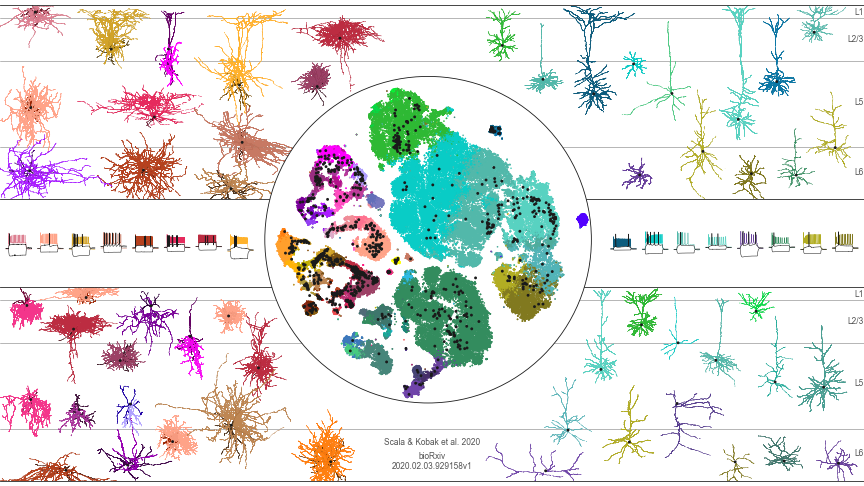

In [10]:
fig = plt.figure(figsize=(7.2, 7.2/16*9))
aspect = 16/9

h = .7
ax_tsne = plt.axes([.5 - h/aspect/2, .5-h/2, h/aspect, h])
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=1, alpha=1,
            c = clusterColors[m1data['neurons']['clusters']], edgecolor='none')

plt.scatter(pos[:,0], pos[:,1], s=3, c='k', zorder=2, edgecolors='none')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_tsne, left=True, bottom=True)

ax_tsne.patch.set_alpha(0)
circle = plt.Circle((0, 0), 115, facecolor='w', zorder=-1, edgecolor='k', linewidth=.5)
# circle = plt.Circle((0, 0), 115, color='w', zorder=-1)
ax_tsne.add_artist(circle)

tsnexlim = ax_tsne.get_xlim()
tsneylim = ax_tsne.get_ylim()

###########################################

ax_cortex = plt.axes([0, .59, 1, .4], zorder=-1)
plt.ylim([-1,0])
plt.xlim([0, aspect/.4])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_cortex, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
for y,L in zip([-0.04,-0.18,-0.5,-0.86], ['L1', 'L2/3', 'L5', 'L6']):
    plt.text(aspect/.4, y, L, fontsize=5, color='#555555', va='center', ha='right') 
    
ax_ephys = plt.axes([0,.45, 1,.1], zorder=-2)
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_ephys, left=True, bottom=True)
plt.xlim([0,30])
plt.ylim([-200,150])

ax_cortex2 = plt.axes([0, 0.01, 1, .4], zorder=-1)
plt.ylim([-1,0])
plt.xlim([0, aspect/.4])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_cortex2, left=True, top=False)
for y in [0.07,0.29,0.73]:
    plt.plot(plt.xlim(), [-y,-y], linewidth=.5, zorder=0, color='#aaaaaa')
for y,L in zip([-0.04,-0.18,-0.5,-0.86], ['L1', 'L2/3', 'L5', 'L6']):
    plt.text(aspect/.4, y, L, fontsize=5, color='#555555', va='center', ha='right') 

plt.text(aspect/.4/2, -.8, 'Scala & Kobak et al. 2020', color='#555555', 
         fontsize=5, va='center', ha='center')
plt.text(aspect/.4/2, -.9, 'bioRxiv\n2020.02.03.929158v1', color='#555555', 
         fontsize=5, va='center', ha='center')
    
    
neurons_to_show = {952: 0,     # L1 Lamp5
                   1232: 0,    # L5 NGC
                   322: .4,    # L2/3 MC
                   574: 1,     # fat Lhx6 NGC
                   779: .5,    # fat L6 Pvalb
                   126: .4,    # L5 HEC
                   328: 1.5,   # L2/3 BC
                   960: 1,     # T-shape MC
                   864: .8,    # bipolar
                   1218: 0,    # L6 Serpinf
                   887: 1,     # L6b Sst,
                   671: 1.5,   # shrub
                   
                   7: 2.9,     # L5 ET
                   1101: 3.2,  # stellate in L4
                   317: 2.7,   # untufted in upper L5
                   59: 3.7,    # deep tufted
                   667: 3.2,   # L6b small
                   797: 4.0,   # L6 CT
                   688: 3.5,   # L6 IT
                   760: 3.77,  # L6 IT small
                   187: 2.5,   # L2/3
                   1202: 3.2,  # NP,
                   168: 4.1,   # L2/3 Rspo
                   1197: 4.15, # L6 IT high
                   14: 3.9,    # smaller ET
                   
                   951: .6,    # Sncg
                   765: 0.5,   # L6 Sncg,
                   1207: 0.3,  # L5 Vip 
                   641: 0,     # deep chandelier
                   985: 0.05,  # chandelier
                   853: .2,    # NGC L1
                   941: 1.1,   # NGC L2/3
                   1213: .8,   # NGC L6
                   332: .2,    # L2/3 BC
                   388: 1.2,   # L5 BC
                   1124: .6,   # L5 Vip
                   1037: 1.5,  # Sst Penk
                   1138: -.05, # L6 Pvalb deep
                   1265: .8,   # L5 Sst crazy
                   315: .5,    # Pvalb Reln
                   821: .9,    # Vip bipolar

                   1273: 2.5,  # L6b wide
                   119: 3.0,   # big L5 IT
                   770: 3.4,   # inverted in L5
                   1228: 3.9,  # NP CT
                   116: 3.8,   # L2/3 IT_2
                   392:  3.2,  # I
                   1170: 3.4,  # J
                   209:  3.6,  # K
                   54:   4.1,  # L
                   915:  2.8,  # M
                   690:  3.1,  # N
                   767:  3.7,  # O
                   1112: 3.9,  # P
                   1244: 4.2,  # Q
                  }

pokemons = {59: 1, 1037: 4, 126: 5, 960: 6, 1101: 7, 574: 16, 767: 17, 322: 25,
            1138: 133, 1124: 677, 187: 10, 116: 11, 951: 12, 864: 19, 1218: 23,
            1170: [28,'A'], 915: 30, 821: 32, 952: 35, 328: 212, 392: 186, 
            317: 194, 209: 202, 1232: 79, 765: 94, 119: 116, 1228: 131, 
            168: 134, 7: 148, 14: 678,  641: 761, 690: 552, 1265: [248, 'S'],
            688: 285, 1202: 188, 887: 50, 388: 47, 667: 43, 332: 126, 
            1207: 39, 1273: 93, 770: 109, 1244: 169, 941: 209, 853: 222, 
            760: [585, 'W'], 797: 253, 1197: 119, 54: 81, 1112: 154, 
            1213: 161, 985: 100, 779: 402, 671: 514, 315: 538,
            }

alphabet = 'abcdefghijklmnopqrstuvwxyz+*#~$€=-><@^ABCDEFGHIJKLMNOPQRSTUVWXYZ'
adj_vert = {'*':-.015, 'i':-.005,'$':-0.01,'€':-0.01,'h':-0.01,'=':-0.01,'~':-0.01}
adj_hor = {960:.05, 574:.05, 
           392:-.1, 1101:-.1, 667:-.05, 1265:.15, 
           1138:.1, 126: .1, 59: -.1,
           767:-.1, 1124: -.1, 187: -.1, 116: -0.07, 864: -.1,
           1170:-.1, 821: -.1, 915: -.1, 317: -.1, 209: -.1,
           765:-.05, 119: -.1, 1228: -.1, 168: -.1, 14: -.1,
           690: -.1, 688: -.1, 1202: .05, 388: -.1, 667: -.1,
           332: -.1, 1207: -.05, 770: -.1, 1244: -.1, 941: -.1, 
           760: -.1, 797: -.1, 1197: -.05, 54: -.05, 1112: -.1,
           1213: -.1, 985: -.07, 671: -.1, 315: -.1,
          }

tsne_adj_hor = {187: 10, 14: 10, 119: -15, 209: -20, 168: -10,
                767: 10, 690: -10, 797: 15, 765: -5, 667: -15,
                853: -5, 941: 10, 1265: -15, 332: -10, 985: 5}
tsne_adj_ver = {168: 10, 767: -10, 688: -15, 1207: -10, 951: 10,
                1273: -5, 1213: 15, 853: 5, 941: 5, 1138: -20,
                1037: -10, 315: -15, 332: 5, 388: -10, 985: -5,
                641: 5}

for num,n in enumerate(neurons_to_show):
    i = n-2
    typ = ttypes['type'][i]
    col = clusterColors[clusterNames==typ][0]
    if np.isin(ttypes['family'][i], ['IT','PT','NP','CT']):
        ax_col = 'none'
        den_col = col
    else:
        ax_col = col
        den_col = [adjust_lightness(col,.4)]
        
    if num<25:
        ax = ax_cortex
    else:
        ax = ax_cortex2    
    
    plot_swc(swcfiles[m1.cells[i]], ax=ax, 
             depth=m1.depth[i], thickness=m1.thickness[i], offset=neurons_to_show[n],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none')

#     if n not in pokemons:
#         dy = 0
#         if alphabet[num] in adj_vert:
#             dy += adj_vert[alphabet[num]]
#         dx = 0
#         if n in adj_hor:
#             dx += adj_hor[n]
#         ax.scatter(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i], 
#                           s=40, c='w', zorder=3, edgecolors=col, linewidth=.5)
#         ax.text(neurons_to_show[n]+dx, -m1.depth[i]/m1.thickness[i]+dy,
#                        alphabet[num], fontsize=5, ha='center', va='center', color=col)

#         good_ind = np.sum(ttypes['qc'][:i]=='good')
#         x = pos[good_ind,0]
#         y = pos[good_ind,1]
#         ax_tsne.scatter(x, y, s=40, c='w', zorder=3, edgecolors='k', linewidth=.5)
#         ax_tsne.text(x, y+dy*100, alphabet[num], fontsize=5, ha='center', va='center', color='k')
#     else:
#         dy = 0
#         if alphabet[num] in adj_vert:
#             dy += adj_vert[alphabet[num]]
#         dx = 0
#         if n in adj_hor:
#             dx += adj_hor[n]
#         if isinstance(pokemons[n], list):
#             pika = plt.imread('figures/pokemons/Shuffle{:03}{}.png'.format(pokemons[n][0],pokemons[n][1]))
#         else:
#             pika = plt.imread('figures/pokemons/Shuffle{:03}.png'.format(pokemons[n]))
#         ax.imshow(pika, extent=[neurons_to_show[n]+dx, neurons_to_show[n]+dx+.15,
#                                 -m1.depth[i]/m1.thickness[i]-.15/2,
#                                 -m1.depth[i]/m1.thickness[i]+.15/2],
#                                 aspect='auto', zorder=10)
#         good_ind = np.sum(ttypes['qc'][:i]=='good')
#         x = pos[good_ind,0]
#         y = pos[good_ind,1]
#         if n in tsne_adj_hor:
#             x += tsne_adj_hor[n]
#         if n in tsne_adj_ver:
#             y += tsne_adj_ver[n]
#         ax_tsne.imshow(pika, extent=[x-10,x+10,y-10,y+10,], zorder=10)    
    
    if num < 8 or (num > 11 and num < 11+9):
        time = three_traces[m1.cells[i]][:,3]
        traces = three_traces[m1.cells[i]][:,:3]
        timeinterval = time<=.9
        time = time[timeinterval]
        traces = traces[timeinterval,:]
        t = time + num*1.1
        if num > 11:
            t += 8
        else:
            t += .2
        ax_ephys.plot(t, traces[:,2], color=col, linewidth=.3)
        ax_ephys.plot(t, traces[:,1], color='k', linewidth=.3)
        ax_ephys.plot(t, traces[:,0], color='k', linewidth=.3)
        
ax_tsne.set_xlim(tsnexlim)
ax_tsne.set_ylim(tsneylim)
    
plt.savefig('../figures/flagship/gotta-patch-them-all-2.png', dpi=300)